In [1]:
pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
# 1. Core Libraries
import numpy as np
import pandas as pd

# 2. Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# 3. Statistics & Modeling
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf  

# 4. Machine Learning (Scikit-learn)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# 5. XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# 6. Deep Learning (Keras)
from keras import models, layers

In [7]:
 # DATA PROCESSING
    
    
    
# Load the dataset and treat specified values as missing (NaN)
df = pd.read_csv('cpi_fyp.csv', na_values=["NA", "N/A", "None", "null", " "])
    
# Drop irrelevant columns
df = df.drop(columns=['Country Code', 'Indicator Code', 'Status', 'Reference Period'])
    
# Remove rows where 'Indicator Name' contains unwanted keywords
df = df[~df['Indicator Name'].str.contains("Percentage change|Weight|Percent", na=False)] 
    
# Drop rows with missing 'Value' entries
df = df.dropna(subset=['Value'])
    
# Convert categorical columns to optimize memory usage
df['Country Name'] = df['Country Name'].astype('category')  
df['Indicator Name'] = df['Indicator Name'].astype('category')
    
# Format 'Time Period' for time-series analysis
df['Time Period'] = df['Time Period'].astype(str).apply(lambda x: x + 'M1' if 'M' not in x else x)
df['Time Period'] = pd.to_datetime(df['Time Period'].str.replace('M', '-'), format='%Y-%m')
    
# Display dataset info
df.info()
df.head

<class 'pandas.core.frame.DataFrame'>
Index: 23903 entries, 12 to 150324
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country Name    23903 non-null  category      
 1   Indicator Name  23903 non-null  category      
 2   Time Period     23903 non-null  datetime64[ns]
 3   Value           23903 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 607.9 KB


<bound method NDFrame.head of              Country Name                                     Indicator Name  \
12              Indonesia                    Consumer Price Index, All items   
13              Indonesia                    Consumer Price Index, All items   
14              Indonesia                    Consumer Price Index, All items   
15              Indonesia                    Consumer Price Index, All items   
16              Indonesia                    Consumer Price Index, All items   
...                   ...                                                ...   
150318           Malaysia  Furnishings, household equipment and routine h...   
150319           Malaysia  Furnishings, household equipment and routine h...   
150320           Malaysia  Furnishings, household equipment and routine h...   
150323  Brunei Darussalam                                      Communication   
150324          Singapore                    Consumer Price Index, All items   

       Ti

In [9]:
# PIVOTING DATA



# Ensure 'Country Name' is explicitly included in the dataset (avoiding issues with indexing)
df = df[['Time Period', 'Country Name', 'Indicator Name', 'Value']]
    
# Pivot the dataset so that each unique 'Indicator Name' becomes a separate column
# This reshapes the data to have one row per 'Time Period' and 'Country Name', with CPI categories as columns
df_col = df.pivot_table(index=["Time Period", "Country Name"], 
                              columns="Indicator Name", 
                              values="Value", 
                              aggfunc="mean")  # Aggregating by mean in case of duplicates
    
# Drop rows with missing values to ensure a complete dataset
df_col.dropna(inplace=True)
    
# Reset index to make 'Country Name' and 'Time Period' regular columns instead of index levels
df_col.reset_index(inplace=True)
    
# Display dataset information and the first few rows for verification
print(df_col.info())
df_col.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 15 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   Time Period                                                         852 non-null    datetime64[ns]
 1   Country Name                                                        852 non-null    category      
 2   Alcoholic Beverages, Tobacco, and Narcotics                         852 non-null    float64       
 3   Clothing and footwear                                               852 non-null    float64       
 4   Communication                                                       852 non-null    float64       
 5   Consumer Price Index, All items                                     852 non-null    float64       
 6   Education                                                 

/var/folders/km/kqnqtg953b76gw0hctk94d1m0000gn/T/ipykernel_12078/239127615.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_col = df.pivot_table(index=["Time Period", "Country Name"],


Indicator Name Time Period Country Name  \
0               2001-01-01     Cambodia   
1               2001-02-01     Cambodia   
2               2001-03-01     Cambodia   
3               2001-04-01     Cambodia   
4               2001-05-01     Cambodia   

Indicator Name  Alcoholic Beverages, Tobacco, and Narcotics  \
0                                                    98.043   
1                                                    97.875   
2                                                    98.244   
3                                                    97.568   
4                                                    97.627   

Indicator Name  Clothing and footwear  Communication  \
0                          102.148417     100.877125   
1                          105.098000     100.434000   
2                          105.092000     100.434000   
3                          103.305000     100.434000   
4                           97.816000     100.434000   

Indicator Name  Consumer Price Index, All items   Education  \
0                                     82.291792  103.326625   
1                                     82.944000  101.053000   
2                                     83.990000  101.053000   
3                                     81.787000  101.053000   
4                                     81.996000  101.053000   

Indicator Name  Food and non-alcoholic beverages  \
0                                       73.58275   
1                                       73.33100   
2                                       75.50300   
3                                       71.96500   
4                                       71.36600   

Indicator Name  Furnishings, household equipment and routine household maintenance  \
0                                                       96.722375                    
1                                                       97.911000                    
2                                                       98.321000                    
3                                                       97.532000                    
4                                                       98.982000                    

Indicator Name   Health  Housing, Water, Electricity, Gas and Other Fuels  \
0               99.5375                                            80.498   
1               97.6860                                            84.483   
2               97.6860                                            84.653   
3               98.8400                                            84.645   
4               99.0740                                            85.258   

Indicator Name  Miscellaneous goods and services  Recreation and culture  \
0                                         90.780                104.0595   
1                                         85.315                106.5750   
2                                         85.566                106.5750   
3                                         84.689                106.5750   
4                                         93.835                108.7530   

Indicator Name  Restaurants and hotels  Transport  
0                           106.974833  77.439833  
1                           108.857000  77.749000  
2                           108.795000  77.863000  
3                            99.044000  77.993000  
4                           101.290000  78.730000

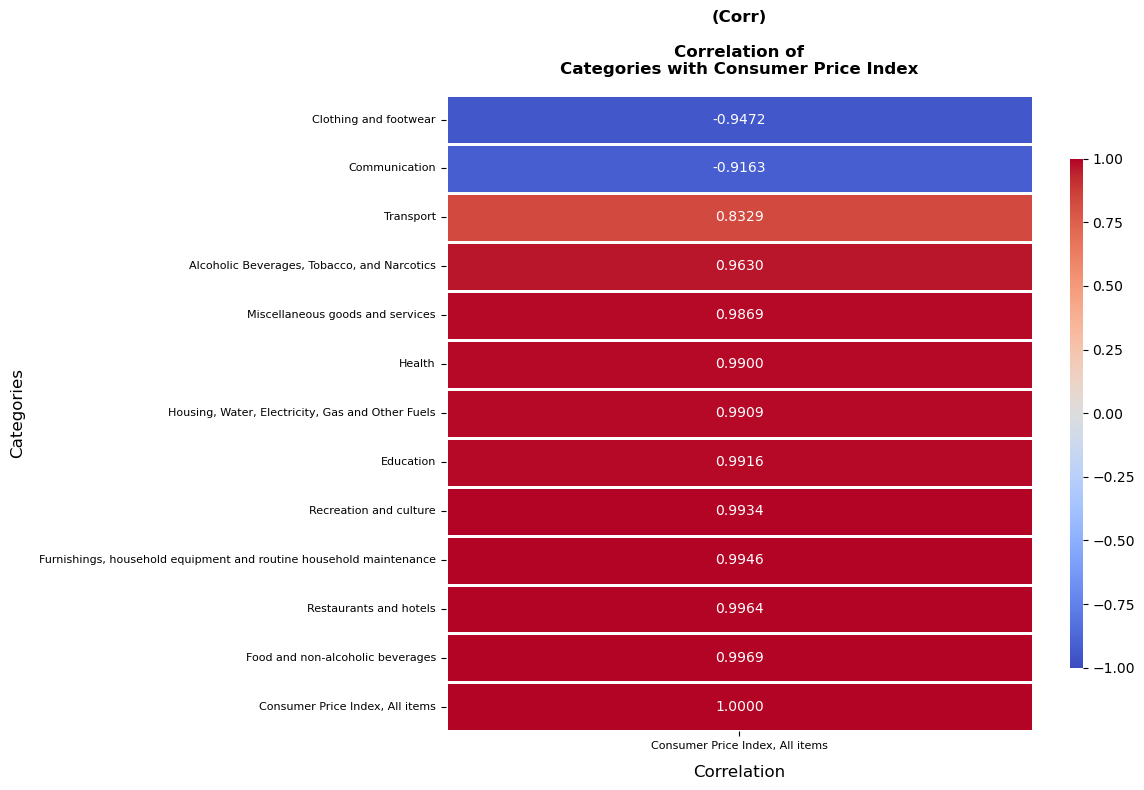

In [17]:
# Filter dataset for Malaysia
df_msia = df_col[df_col["Country Name"] == "Malaysia"]
    
# Drop non-numeric columns
df_msia = df_msia.drop(['Country Name', 'Time Period'], axis=1)
    
# Calculate correlation with 'Consumer Price Index, All Items'
cpi_correlation = df_msia.corr()['Consumer Price Index, All items'].sort_values(ascending=True)  # Sorted in ascending order
    
# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cpi_correlation.to_frame(),
                annot=True,  # Show correlation values
                fmt=".4f",  # Limit decimal places for clarity
                cmap='coolwarm',  # Use a contrasting color palette
                linewidths=1,  # Increase grid line thickness for better separation
                linecolor='white',  # White grid lines for better contrast
                cbar_kws={"shrink": 0.8, "aspect": 40},  # Adjust color bar size
                vmin=-1, vmax=1)  # Standardized color scale for consistency
    
# Improve title and axis labels
plt.title("(Corr)\n\nCorrelation of\nCategories with Consumer Price Index", 
              fontsize=12, fontweight='bold', pad=15)
plt.ylabel("Categories", fontsize=12, labelpad=10)
plt.xlabel("Correlation", fontsize=12, labelpad=10)
    
# Adjust layout to prevent overlap
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
    
# Show the heatmap
plt.show()

In [19]:
# SVR 



# Assuming df_pivot is your pivoted DataFrame containing all columns
# Filter data for Malaysia only
df_msia = df_col[df_col["Country Name"] == "Malaysia"]
    
# Drop the 'Country Name' and 'Time Period' columns, SVR requires Numerical Input
df_msia = df_msia.drop(['Country Name', 'Time Period'], axis=1)

In [21]:
# Define target variable
target_column = 'Consumer Price Index, All items'
    
# Keep only the most correlated features
selected_features = [
        'Furnishings, household equipment and routine household maintenance', 
        'Restaurants and hotels', 
        'Food and non-alcoholic beverages'
    ]
    
# Extract the selected features and target
X = df_msia[selected_features]
y = df_msia[target_column]
    
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Standardize the features (SVR is sensitive to feature scaling)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
    
# Reshape y_train and y_test to 2D arrays for scaling
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)
    
# Scale features and target
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

In [25]:
# Define parameter grid
param_grid = {
        'kernel': ['rbf', 'poly', 'sigmoid'],  
        'C': [1, 10, 100, 1000],  
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
        'epsilon': [0.01, 0.1, 0.2]
    }
    
# Initialize GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train_scaled.ravel())
    
# Extract best parameters and score
best_params = grid_search.best_params_
    
# Best model parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 1, 'kernel': 'rbf'}


In [27]:
# Initialize the SVR model
svr = SVR(kernel='rbf', C=100, gamma=1, epsilon=0.01)
    
# Train the model
svr.fit(X_train_scaled, y_train_scaled.ravel())
    
# Make predictions on the test set
y_pred_scaled = svr.predict(X_test_scaled)
    
# Inverse transform the predicted and actual values to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test_scaled)

In [29]:
# Calculate MAE, MSE, RMSE, and R²
mae_svr = mean_absolute_error(y_test_original, y_pred)  # Mean Absolute Error
mse_svr = mean_squared_error(y_test_original, y_pred)  # Mean Squared Error
rmse_svr = np.sqrt(mse_svr)  # Root Mean Squared Error
r2_svr = r2_score(y_test_original, y_pred)  # R² (Coefficient of Determination)
    
# Print the results
print(f"Mean Absolute Error (MAE): {mae_svr}")
print(f"Mean Squared Error (MSE): {mse_svr}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr}")
print(f"R² Score: {r2_svr}")

Mean Absolute Error (MAE): 0.38088079142968745
Mean Squared Error (MSE): 0.43402841312449514
Root Mean Squared Error (RMSE): 0.6588083280624912
R² Score: 0.9976610905282498


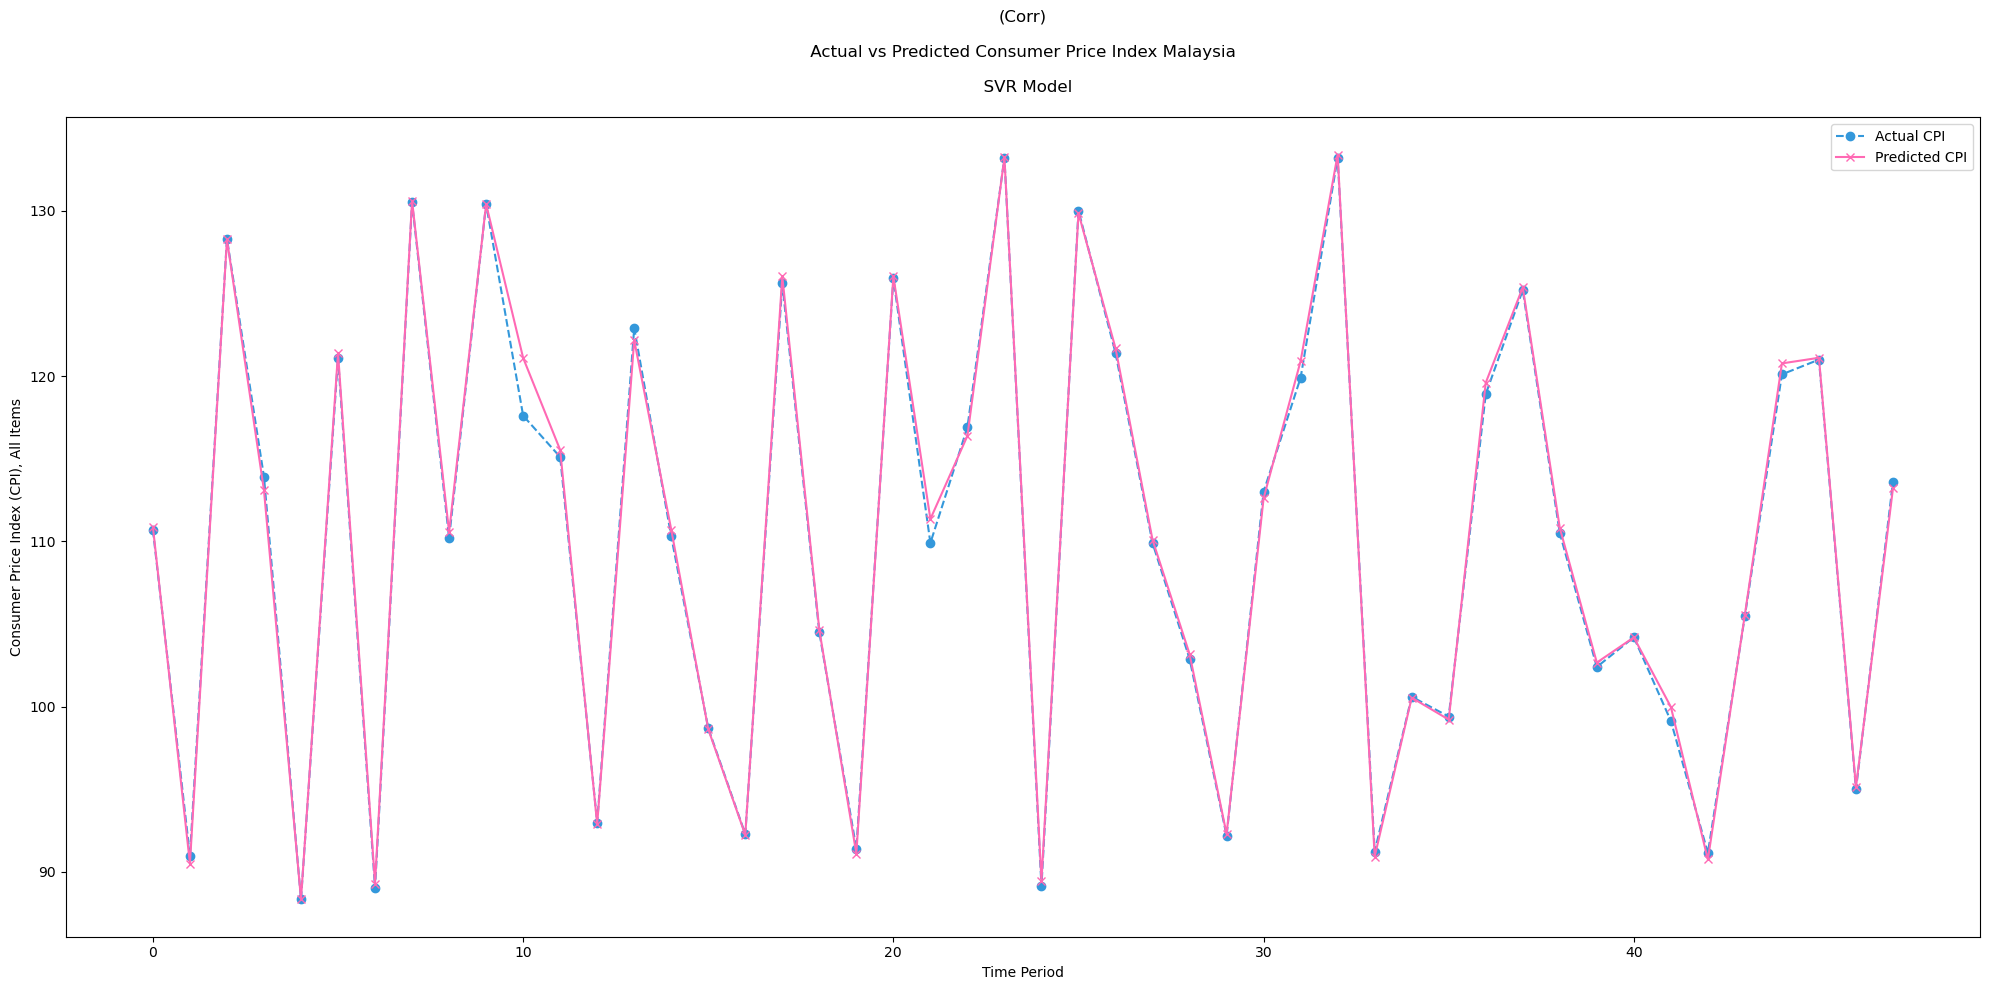

In [31]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 10))
plt.plot(y_test_original, label="Actual CPI", marker="o", linestyle="--", color="#3498DB")
plt.plot(y_pred, label="Predicted CPI", marker="x", linestyle="-", color="#FF69B4")
plt.legend()
plt.xlabel("Time Period")
plt.ylabel("Consumer Price Index (CPI), All Items")
plt.title("(Corr)\n\n Actual vs Predicted Consumer Price Index Malaysia \n\n  SVR Model\n ")
plt.tight_layout()
plt.show()

In [33]:
# RANDOM FOREST 
    
    
    
# Assuming df_pivot is your pivoted DataFrame containing all columns
# Filter data for Malaysia only
df_msia = df_col[df_col["Country Name"] == "Malaysia"]
    
# Drop the 'Country Name' and 'Time Period' columns, SVR requires Numerical Input
df_msia = df_msia.drop(['Country Name', 'Time Period'], axis=1)

In [35]:
# Define target variable
target_column = 'Consumer Price Index, All items'
    
# Keep only the most correlated features
selected_features = [
        'Furnishings, household equipment and routine household maintenance', 
        'Restaurants and hotels', 
        'Food and non-alcoholic beverages'
    ]
    
# Extract the selected features and target
X = df_msia[selected_features]
y = df_msia[target_column]
    
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Standardize the features (Random Forest is less sensitive to scaling, but it helps)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
# Define parameter grid for GridSearchCV
param_grid = {
        "n_estimators": [50, 100, 200],  # Number of trees
        "max_depth": [10, 20, None],  # Depth of trees
        "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
        "min_samples_leaf": [1, 2, 4]  # Minimum samples required at a leaf node
    }
    
# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)
    
# Train the model using GridSearchCV
grid_search.fit(X_train_scaled, y_train)
    
# Best model parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END ........C=1, epsilon=0.01, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=1, epsilon=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.01, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ..........C=1, epsilon=0.01, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........C=1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......C=1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1, epsilon=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......C=1, epsilon=0.1, gamma=scale, k

In [41]:
# Train final model with best parameters
rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_train_scaled, y_train)
    
# Make predictions
y_pred = rf_model.predict(X_test_scaled)

In [43]:
# Model evaluation
mae_rf = mean_absolute_error(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)
    
# Print performance metrics
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R² Score: {r2_rf}")

Mean Absolute Error (MAE): 0.32650455482382706
Mean Squared Error (MSE): 0.3939732157794724
Root Mean Squared Error (RMSE): 0.6276728572907008
R² Score: 0.9978769415592657


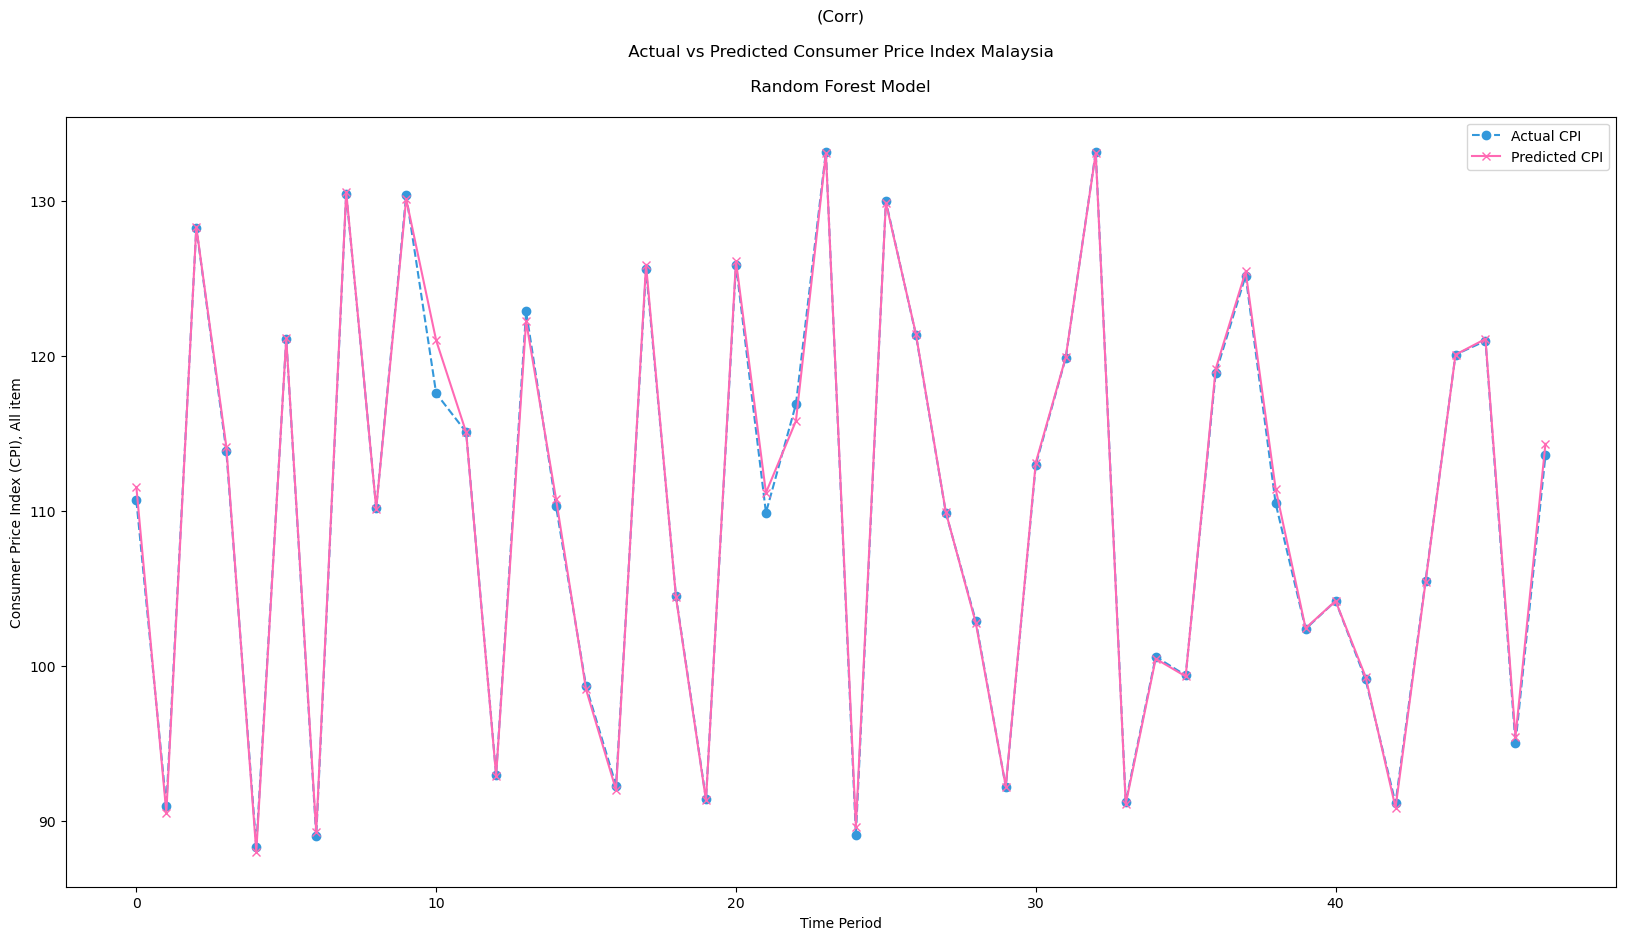

In [45]:
# Plot actual vs predicted CPI
plt.figure(figsize=(20, 10))
plt.plot(y_test.values, label="Actual CPI", marker="o", linestyle="--", color="#3498DB")
plt.plot(y_pred, label="Predicted CPI", marker="x", linestyle="-", color="#FF69B4")
plt.legend()
plt.xlabel("Time Period")
plt.ylabel("Consumer Price Index (CPI), All item")
plt.title("(Corr)\n\n Actual vs Predicted Consumer Price Index Malaysia \n\n Random Forest Model \n")
plt.show()

In [47]:
# XGBOOST



# Filter the DataFrame to select Malaysia only
df_msia = df_col[df_col["Country Name"] == "Malaysia"].copy()
    
# Drop the 'Country Name' and 'Time Period' columns, SVR requires Numerical Input
df_msia = df_msia.drop(['Country Name', 'Time Period'], axis=1)

In [49]:
# Define target variable
target_column = 'Consumer Price Index, All items'
    
# Keep only the most correlated features
selected_features = [
        'Furnishings, household equipment and routine household maintenance', 
        'Restaurants and hotels', 
        'Food and non-alcoholic beverages'
    ]
    
# Extract the selected features and target
X = df_msia[selected_features]
y = df_msia[target_column]
    
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Standardize the features (Random Forest is less sensitive to scaling, but it helps)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
# Define parameter grid for XGBoost
param_grid_xgb = {
        'n_estimators': [100, 300, 500],  
        'max_depth': [3, 5, 7],  
        'learning_rate': [0.01, 0.05, 0.1],  
        'subsample': [0.8, 1.0],  
        'colsample_bytree': [0.8, 1.0]  
    }
    
# Initialize GridSearchCV with XGBRegressor
grid_search_xgb = GridSearchCV(XGBRegressor(objective="reg:squarederror", random_state=42), 
                                   param_grid_xgb, 
                                   cv=5, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)
    
# Train the model using GridSearchCV
grid_search_xgb.fit(X_train_scaled, y_train)
    
# Best model parameters
best_params_xgb = grid_search_xgb.best_params_
print(f"Best Parameters for XGBoost: {best_params_xgb}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END ........C=1, epsilon=0.01, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......C=1, epsilon=0.01, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, epsilon=0.01, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......C=1, epsilon=0.01, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .............C=1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .............C=1, epsilon=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........C=1, epsilon=0.01, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=sca

In [55]:
# Train final model using best parameters
xgb_model = xgb.XGBRegressor(**best_params_xgb, objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train_scaled, y_train)
    
# Make predictions
y_pred = xgb_model.predict(X_test_scaled)

In [57]:
# Evaluate performance
mae_xgb = mean_absolute_error(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)
    
# Print results
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"R² Score: {r2_xgb}")

Mean Absolute Error (MAE): 0.4025429878902174
Mean Squared Error (MSE): 0.432903438808234
Root Mean Squared Error (RMSE): 0.6579539792479668
R² Score: 0.9976671528343205


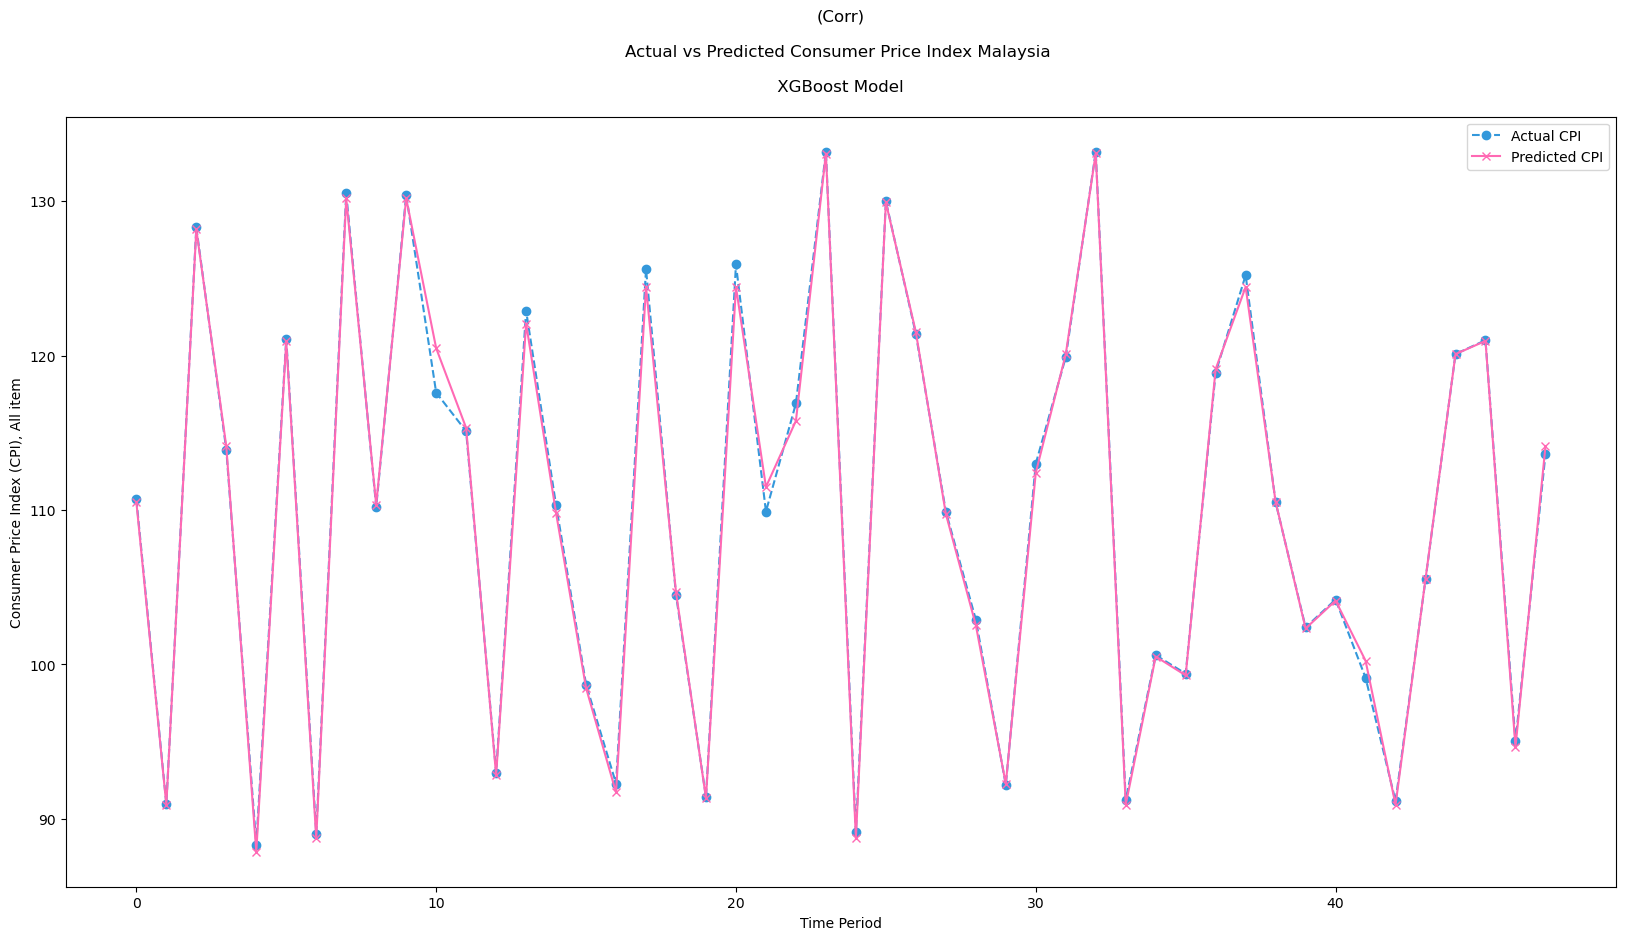

In [59]:
# Plot actual vs predicted CPI
plt.figure(figsize=(20, 10))
plt.plot(y_test.values, label="Actual CPI", marker="o", linestyle="--", color="#3498DB")
plt.plot(y_pred, label="Predicted CPI", marker="x", linestyle="-", color="#FF69B4")
plt.legend()
plt.xlabel("Time Period")
plt.ylabel("Consumer Price Index (CPI), All item")
plt.title("(Corr)\n\nActual vs Predicted Consumer Price Index Malaysia \n\n XGBoost Model \n ")
plt.show()

In [61]:
# NEURAL NETWORK



# Filter the DataFrame to select Malaysia only
df_msia = df_col[df_col["Country Name"] == "Malaysia"].copy()
    
# Drop the 'Country Name' and 'Time Period' columns, SVR requires Numerical Input
df_msia = df_msia.drop(['Country Name', 'Time Period'], axis=1)

In [63]:
# Define target variable
target_column = 'Consumer Price Index, All items'
    
# Keep only the most correlated features
selected_features = [
        'Furnishings, household equipment and routine household maintenance', 
        'Restaurants and hotels', 
        'Food and non-alcoholic beverages'
    ]
    
# Extract the selected features and target
X = df_msia[selected_features]
y = df_msia[target_column]
    
# Split into training and testing sets
train_data, test_data, train_targets, test_targets = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
print('Size of the training set: ', train_data.shape)
print('Size of the test set: ', test_data.shape)

Size of the training set:  (189, 3)
Size of the test set:  (48, 3)


In [67]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [69]:
model = models.Sequential()
model.add(layers.Dense(128, # The number of neurons
                          activation = 'relu', # The type of activation
                          input_shape = (3,)  # The input shape. It is only necessary for the layer connected to the input.
                          ))
model.add(layers.Dense(64, activation = 'relu')) 
model.add(layers.Dense(1, activation = 'linear'))
model.compile(optimizer = 'rmsprop', loss = 'mse')
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 8,833 (34.50 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
history = model.fit(train_data, train_targets, epochs = 100, batch_size=16,
                        validation_split= 0.2)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12377.1367 - val_loss: 12183.7812
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11762.2324 - val_loss: 11732.8467
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11243.3906 - val_loss: 11182.1260
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10767.5449 - val_loss: 10540.0508
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10275.5342 - val_loss: 9781.9814
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9417.4287 - val_loss: 8932.7705
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8499.6807 - val_loss: 8003.1792
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7574.5601 - val_loss: 7078.2041
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6662.3271 - val_loss: 6130.7163
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5706.3901 - val_loss: 5227.6167
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5341.6733 - val_loss

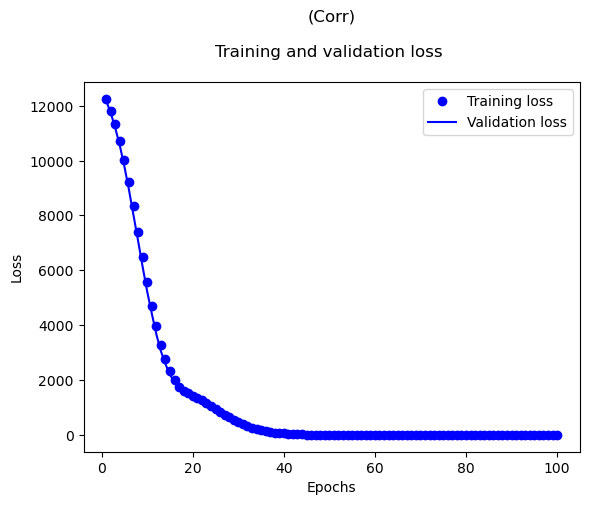

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('(Corr)\n\nTraining and validation loss \n ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
model.evaluate(test_data, test_targets)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1050


2.0166618824005127

In [79]:
# Make predictions on the test data
predictions = model.predict(test_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [81]:
# Calculate evaluation metrics
mae_nn = mean_absolute_error(test_targets, predictions)
mse_nn = mean_squared_error(test_targets, predictions)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(test_targets, predictions)
    
# Print the results
print(f"Mean Absolute Error (MAE): {mae_nn}")
print(f"Mean Squared Error (MSE): {mse_nn}")
print(f"Root Mean Squared Error (RMSE): {rmse_nn}")
print(f"R² Score: {r2_nn}")

Mean Absolute Error (MAE): 1.2402172647111016
Mean Squared Error (MSE): 2.0166616384998517
Root Mean Squared Error (RMSE): 1.4200921232440702
R² Score: 0.9891325340347022


In [83]:
# Define the error metrics for each model
metrics = {
        "Model": ["SVR", "Random Forest", "XGBoost", "Neural Network"],
        "MAE": [mae_svr, mae_rf, mae_xgb, mae_nn],
        "MSE": [mse_svr, mse_rf, mse_xgb, mse_nn],
        "RMSE": [rmse_svr, rmse_rf, rmse_xgb, rmse_nn],
        "R² Score": [r2_svr, r2_rf, r2_xgb, r2_nn]
    }
    
# Create a DataFrame to compare the models
comparison_df = pd.DataFrame(metrics)
    
# Display the comparison table
print(comparison_df)

            Model       MAE       MSE      RMSE  R² Score
0             SVR  0.380881  0.434028  0.658808  0.997661
1   Random Forest  0.326505  0.393973  0.627673  0.997877
2         XGBoost  0.402543  0.432903  0.657954  0.997667
3  Neural Network  1.240217  2.016662  1.420092  0.989133
